# Bootstrap

In [251]:
import numpy as np
import pandas as pd
import scipy
from scipy import integrate
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
from tqdm import tqdm
from scipy.special import digamma, gamma

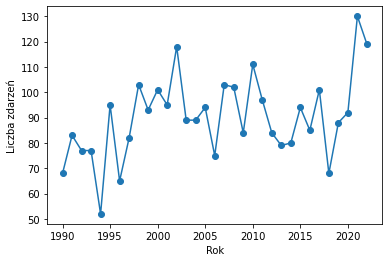

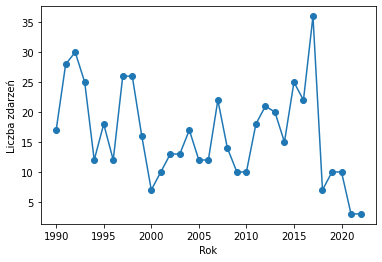

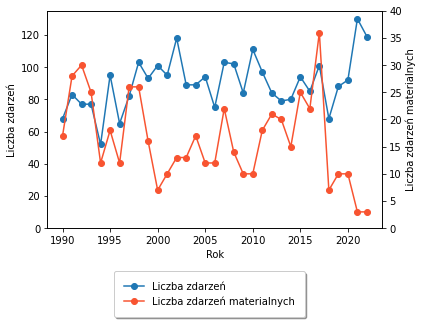

C:\Users\ndzad\AppData\Local\Temp/ipykernel_15648/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


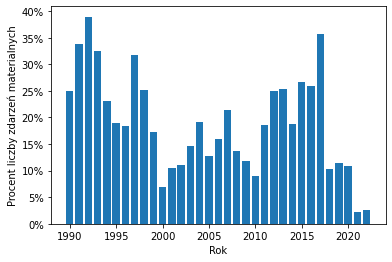

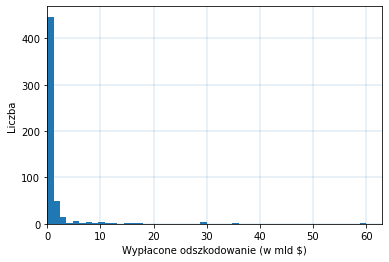

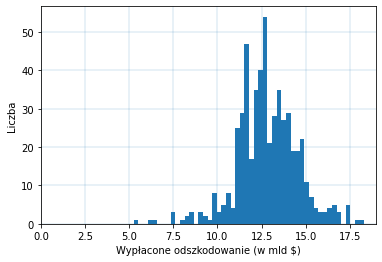

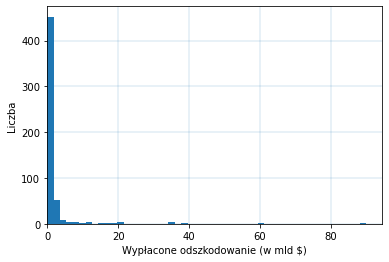

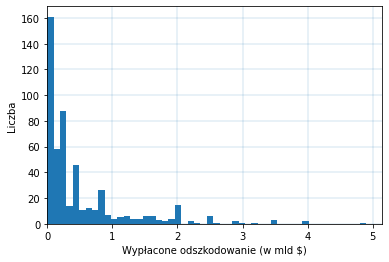

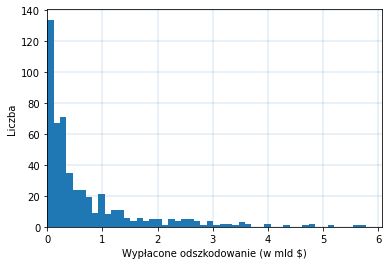

In [37]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_liczby_roszczen.ipynb"

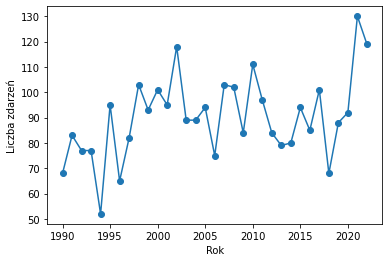

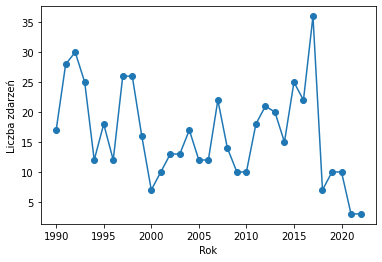

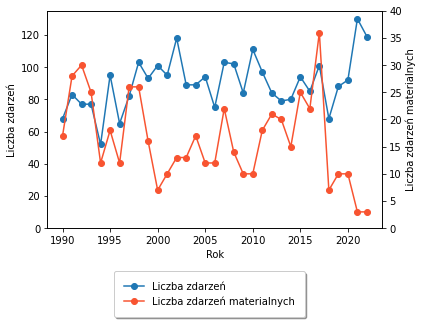

C:\Users\ndzad\AppData\Local\Temp/ipykernel_15648/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


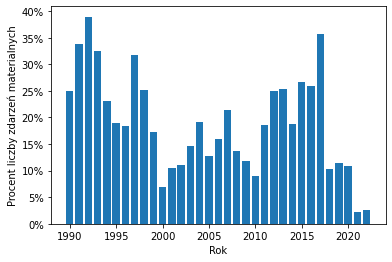

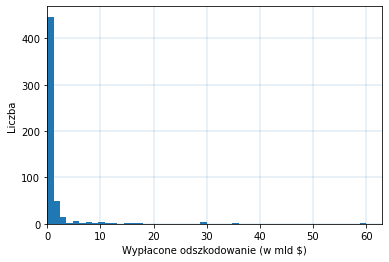

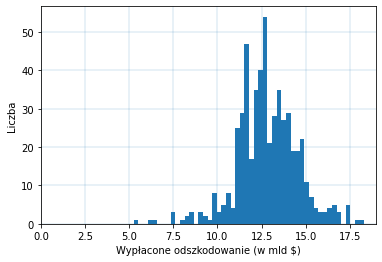

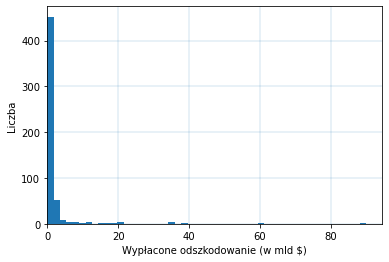

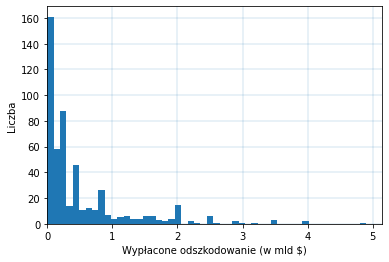

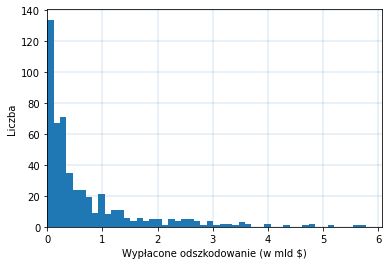

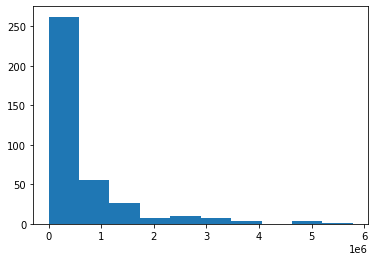

1.667e-06


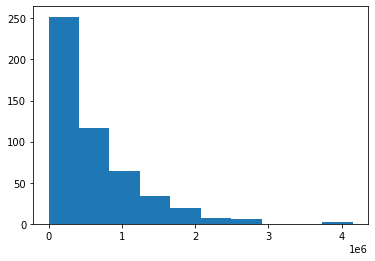

       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
12.47 2.07
12.46672547764283 2.074318127197053


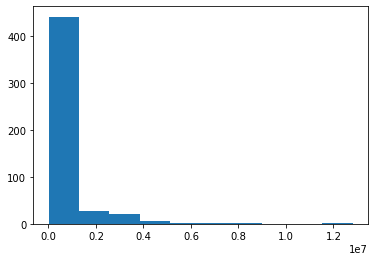

       rozkład test  Wartość statystyki   p value
0  Lognormalny   KS                0.06  0.120754
1  Lognormalny   CM                0.21  0.244276
0.72 1.1988586302925719e-06


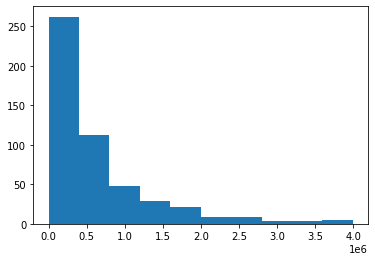

  rozkład test  Wartość statystyki   p value
0   Gamma   KS                0.13  0.000012
1   Gamma   CM                1.02  0.002138
0.786188921301622 514170.5554941683


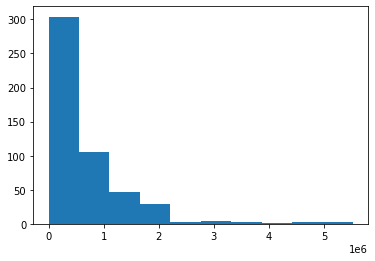

    rozkład test  Wartość statystyki   p value
0  Weibulla   KS                0.10  0.001004
1  Weibulla   CM                0.59  0.023748


c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1.861639368063435 0.043086409391061675
  rozkład test  Wartość statystyki       p value
0   Burra   KS                0.51  4.854888e-90
1   Burra   CM               29.38  4.346694e-09
       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
2  Lognormalny   KS                0.06  1.207536e-01
3  Lognormalny   CM                0.21  2.442758e-01
4        Gamma   KS                0.13  1.164551e-05
5        Gamma   CM                1.02  2.137666e-03
6     Weibulla   KS                0.10  1.004223e-03
7     Weibulla   CM                0.59  2.374758e-02
8        Burra   KS                0.51  4.854888e-90
9        Burra   CM               29.38  4.346694e-09


In [286]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"

In [32]:
T = pd.DataFrame({'t':[1990 + t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
for r in range(1991,2023):
    if r%4==0:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    else:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
T.reset_index(drop=True,inplace=True)

In [33]:
N = pd.merge(T, data_wo[['t','Ind']], on='t', how='left').fillna(0).groupby('t').sum().cumsum().assign(Year=np.floor(pd.merge(T, data_wo[['t','Ind']], on='t', how='left')['t']))
N = N.assign(Year=np.floor(N.index))
n = N.groupby('Year').max('Ind').diff().fillna(float(N.groupby('Year').max('Ind').head(1)['Ind'])).rename(columns = {'Ind':'n'})

T_train = T[T['t']<2013]
t_train = T_train['t'] - 1990
n_train = n[n.index<=2012]
N_train = N[N['Year']<=2012]

T_test = T[T['t']>=2013]
t_test = T_test['t'] - 2013
n_test = n[n.index>2012]
N_test = N[N['Year']>2012]

## Bootstrap

### Klasyczny bootstrap

In [25]:
number_of_simulations = 500

In [ ]:
def bootstrap(data, S ,B):
    """
    Argumenty:
        data: pd.Series
            Ciąg z którego próbkujemy
        S: fun
            Statystka
        B: float
            Liczba próbek bootstrapowych
    Zwraca:
        bootstrap_data: pd.Series
            Próba bootstrapowa          
    """    
    X = []
    for i in range(B):
        X.append(S(pd.Series(data).sample(len(data),replace=True)))
    if B == len(data):
        index_temp = data.index
    else:
        index_temp = range(B)

    bootstrap_data = pd.Series(X, name=data.name)
    
    return(bootstrap_data)

In [146]:
def bootstrap(data,distribution, B):
    """
    Argumenty:
        data: pd.Series
            Ciąg z którego próbkujemy
        distribution: fun
            Przyjęty rozkład
        B: float
            Liczba próbek bootstrapowych
    Zwraca:
        bootstrap_data: pd.Series
            Próba bootstrapowa          
    """
    if distribution == "exp":
        params = [[]]
    else:
        params = [[],[]]

    for i in range(B):
        X = pd.Series(data).sample(len(data),replace=True)
        if distribution == "exp":
            params[0].append(len(X)/sum(X))
        elif distribution == "ln":
            params[0].append(sum(np.log(X))/len(X))
            params[1].append(sum(np.square(np.log(X)-sum(np.log(X))/len(X)))/len(X))
        elif distribution == "gamma":
            params[0].append(stats.gamma.fit(X,floc=0)[0])
            params[1].append(1/stats.gamma.fit(X,floc=0)[2])
        elif distribution == "weibull":
            params[0].append(stats.weibull_min.fit(X,floc=0)[0])
            params[1].append(stats.weibull_min.fit(X,floc=0)[2])
        elif distribution == "burr":
            params[0].append(stats.burr12.fit(X,floc=0,fscale=1)[0])
            params[1].append(stats.burr12.fit(X,floc=0,fscale=1)[1])

    return(params)

In [147]:
exp_lambda_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"exp",number_of_simulations)[0]
ln_mu_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"ln",number_of_simulations)[0]
ln_sigma_sq_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"ln",number_of_simulations)[1]
gamma_alfa_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"gamma",number_of_simulations)[0]
gamma_beta_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"gamma",number_of_simulations)[1]
weibull_k_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"weibull",number_of_simulations)[0]
weibull_lambda_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"weibull",number_of_simulations)[1]
burr_c_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"burr",number_of_simulations)[0]
burr_k_bootstrap = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"],"burr",number_of_simulations)[1]


c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [26]:
exp_lambda_bootstrap = []
ln_mu_bootstrap = []
ln_sigma_sq_bootstrap = []
gamma_alfa_bootstrap = []
gamma_beta_bootstrap = []
weibull_k_bootstrap = []
weibull_lambda_bootstrap = []
burr_c_bootstrap = []
burr_k_bootstrap = []

for i in range(number_of_simulations):
    damages = bootstrap(train["Insured Damages, Adjusted (\'000 US$)"], np.mean, len(train["Insured Damages, Adjusted (\'000 US$)"]))

    exp_lambda_bootstrap.append(len(damages)/sum(damages))
    ln_mu_bootstrap.append(sum(np.log(damages))/len(damages))
    ln_sigma_sq_bootstrap.append(sum(np.square(np.log(damages)-sum(np.log(damages))/len(damages)))/len(damages))
    gamma_alfa_bootstrap.append(stats.gamma.fit(damages,floc=0)[0])
    gamma_beta_bootstrap.append(1/stats.gamma.fit(damages,floc=0)[2])
    weibull_k_bootstrap.append(stats.weibull_min.fit(damages,floc=0)[0])
    weibull_lambda_bootstrap.append(stats.weibull_min.fit(damages,floc=0)[2])
    burr_c_bootstrap.append(stats.burr12.fit(damages,floc=0,fscale=1)[0])
    burr_k_bootstrap.append(stats.burr12.fit(damages,floc=0,fscale=1)[1])

c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [206]:
exp_lambda_bootstrap_avg = np.mean(exp_lambda_bootstrap)
exp_lambda_bootstrap_5p = np.percentile(exp_lambda_bootstrap,5)
exp_lambda_bootstrap_95p = np.percentile(exp_lambda_bootstrap,95)

ln_mu_bootstrap_avg = np.mean(ln_mu_bootstrap)
ln_mu_bootstrap_5p = np.percentile(ln_mu_bootstrap,5)
ln_mu_bootstrap_95p = np.percentile(ln_mu_bootstrap,95)

ln_sigma_sq_bootstrap_avg = np.mean(ln_sigma_sq_bootstrap)
ln_sigma_sq_bootstrap_5p = np.percentile(ln_sigma_sq_bootstrap,5)
ln_sigma_sq_bootstrap_95p = np.percentile(ln_sigma_sq_bootstrap,95)

gamma_alfa_bootstrap_avg = np.mean(gamma_alfa_bootstrap)
gamma_alfa_bootstrap_5p = np.percentile(gamma_alfa_bootstrap,5)
gamma_alfa_bootstrap_95p = np.percentile(gamma_alfa_bootstrap,95)

gamma_beta_bootstrap_avg = np.mean(gamma_beta_bootstrap)
gamma_beta_bootstrap_5p = np.percentile(gamma_beta_bootstrap,5)
gamma_beta_bootstrap_95p = np.percentile(gamma_beta_bootstrap,95)

weibull_k_bootstrap_avg = np.mean(weibull_k_bootstrap)
weibull_k_bootstrap_5p = np.percentile(weibull_k_bootstrap,5)
weibull_k_bootstrap_95p = np.percentile(weibull_k_bootstrap,95)

weibull_lambda_bootstrap_avg = np.mean(weibull_lambda_bootstrap)
weibull_lambda_bootstrap_5p = np.percentile(weibull_lambda_bootstrap,5)
weibull_lambda_bootstrap_95p = np.percentile(weibull_lambda_bootstrap,95)

burr_c_bootstrap_avg = np.mean(burr_c_bootstrap)
burr_c_bootstrap_5p = np.percentile(burr_c_bootstrap,5)
burr_c_bootstrap_95p = np.percentile(burr_c_bootstrap,95)

burr_k_bootstrap_avg = np.mean(burr_k_bootstrap)
burr_k_bootstrap_5p = np.percentile(burr_k_bootstrap,5)
burr_k_bootstrap_95p = np.percentile(burr_k_bootstrap,95)

In [290]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_bootstrap_avg),
                    round(ln_mu_bootstrap_avg,2),
                    round(ln_sigma_sq_bootstrap_avg,2),
                    round(gamma_alfa_bootstrap_avg,2),
                    "{:e}".format(gamma_beta_bootstrap_avg),
                    round(weibull_k_bootstrap_avg,2),
                    round(weibull_lambda_bootstrap_avg,2),
                    round(burr_c_bootstrap_avg,2),
                    round(burr_k_bootstrap_avg,2),
        ],
    'Rożnice' : [
                    exp_lambda_bootstrap_avg-exp_lambda,
                    ln_mu_bootstrap_avg-ln_mu,
                    ln_sigma_sq-ln_sigma_sq_bootstrap_avg,
                    gamma_alfa_bootstrap_avg-gamma_alfa,
                    gamma_beta_bootstrap_avg-gamma_beta,
                    weibull_k_bootstrap_avg-weibull_k,
                    weibull_lambda_bootstrap_avg-weibull_lambda,
                    burr_c_bootstrap_avg-burr_c,
                    burr_k_bootstrap_avg-burr_k,                
        ]
}))

       rozkład  Parametr       Wartość       Rożnice
0  Wykładniczy    lambda  1.679673e-06  1.218516e-08
1  Lognormalny        mu         12.46 -2.383984e-03
2  Lognormalny  sigma_sq          2.08 -2.124620e-03
3        Gamma      alfa          0.72  4.650126e-03
4        Gamma      beta  1.215101e-06  1.624264e-08
5     Weibulla         k          0.79  3.803385e-03
6     Weibulla    lambda     513403.98 -7.665752e+02
7        Burra         c          1.89  2.762976e-02
8        Burra         k          0.04 -3.805452e-04


In [ ]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_bootstrap_avg),
                    round(ln_mu_bootstrap_avg,2),
                    round(ln_sigma_sq_bootstrap_avg,2),
                    round(gamma_alfa_bootstrap_avg,2),
                    "{:e}".format(gamma_beta_bootstrap_avg),
                    round(weibull_k_bootstrap_avg,2),
                    round(weibull_lambda_bootstrap_avg,2),
                    round(burr_c_bootstrap_avg,2),
                    round(burr_k_bootstrap_avg,2),
        ]
}))

In [207]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_bootstrap_5p),
                    round(ln_mu_bootstrap_5p,2),
                    round(ln_sigma_sq_bootstrap_5p,2),
                    round(gamma_alfa_bootstrap_5p,2),
                    "{:e}".format(gamma_beta_bootstrap_5p),
                    round(weibull_k_bootstrap_5p,2),
                    round(weibull_lambda_bootstrap_5p,2),
                    round(burr_c_bootstrap_5p,2),
                    round(burr_k_bootstrap_5p,2),
        ]
}))

       rozkład  Parametr       Wartość
0  Wykładniczy    lambda  1.478864e-06
1  Lognormalny        mu         12.59
2  Lognormalny  sigma_sq          1.77
3        Gamma      alfa          0.66
4        Gamma      beta  1.018896e-06
5     Weibulla         k          0.74
6     Weibulla    lambda     459268.26
7        Burra         c          1.77
8        Burra         k          0.04


In [208]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_bootstrap_95p),
                    round(ln_mu_bootstrap_95p,2),
                    round(ln_sigma_sq_bootstrap_95p,2),
                    round(gamma_alfa_bootstrap_95p,2),
                    "{:e}".format(gamma_beta_bootstrap_95p),
                    round(weibull_k_bootstrap_95p,2),
                    round(weibull_lambda_bootstrap_95p,2),
                    round(burr_c_bootstrap_95p,2),
                    round(burr_k_bootstrap_95p,2),
        ]
}))

       rozkład  Parametr       Wartość
0  Wykładniczy    lambda  1.893190e-06
1  Lognormalny        mu         12.59
2  Lognormalny  sigma_sq          2.39
3        Gamma      alfa           0.8
4        Gamma      beta  1.464117e-06
5     Weibulla         k          0.84
6     Weibulla    lambda     566071.23
7        Burra         c          2.01
8        Burra         k          0.05


In [38]:
sin_params = scipy.optimize.curve_fit(cum_sin_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]
power_law_params = scipy.optimize.curve_fit(cum_power_law_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]

In [44]:
loss_full = pd.merge(T, data_wo[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_full = loss_full.cumsum()

In [45]:
loss_train = pd.merge(T_train, train[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_train = loss_train.cumsum()

In [46]:
loss_test = pd.merge(T_test, test[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_test = loss_test.cumsum()

In [47]:
def loss_pred(t, n, damages, t_index):
    """
    Funkcja generuje proces dla zaobserwowanych zdarzeń.

    Argumenty:
        t: array
            Przestrzeń czasów
        n: array
            Zaobserowane czasy zdarzenia
        damages: array
            Straty
        t_index: array
            Pożądane indeksy
    Zwraca:
        pandas.Series
            Tablica czasów.
    """
    df = pd.DataFrame({'t':n, 'damages':damages}).set_index('t')
    counts = [sum([1 for x in n if x <= y]) for y in t]
    values = [sum([df['damages'][x] for x in n if x <= y]) for y in t]
    return(pd.DataFrame({'n' : counts, 'damages': values}, index = t_index))

## Straty - avg

### Rozkład wykładniczy

Sinusoidalna funkcja intensywności

In [152]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootstrap_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_exp_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_exp_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_exp_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [51:35<00:00,  6.19s/it] 


In [209]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootstrap_5p,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_exp_bootstrap_5p_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootstrap_5p_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootstrap_5p_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_exp_5p_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_exp_5p_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:00:26<00:00,  7.25s/it]


In [210]:
print(MSE_sin_exp_5p_bootstrap,MAE_sin_exp_5p_bootstrap)

8.58051935768858e+16 292463713.2199056


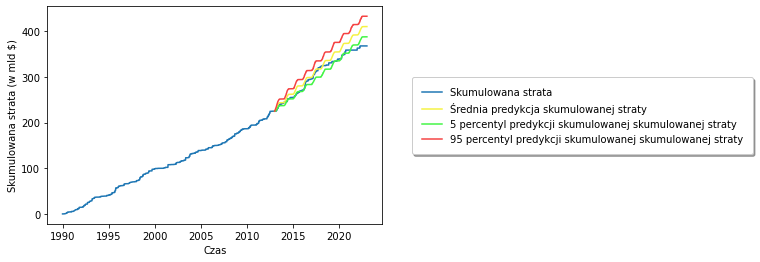

In [153]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_exp_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_exp_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_exp_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_exp_sin_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [154]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootstrap_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_exp_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_exp_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_power_law_exp_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [47:25<00:00,  5.69s/it]  


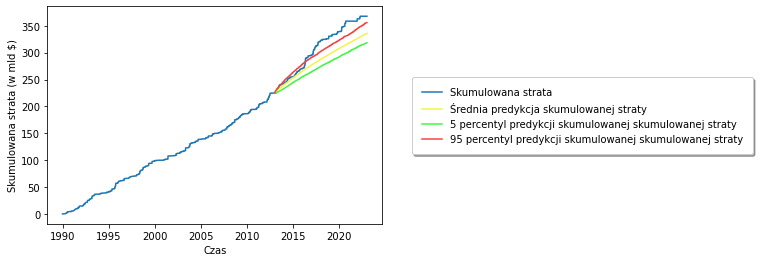

In [155]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_exp_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_exp_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_exp_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_exp_power_law_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład lognormalny

Sinusoidalna funkcja intensywności

In [156]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootstrap_avg),scale=np.exp(ln_mu_bootstrap_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_ln_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_ln_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_ln_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [55:34<00:00,  6.67s/it]  


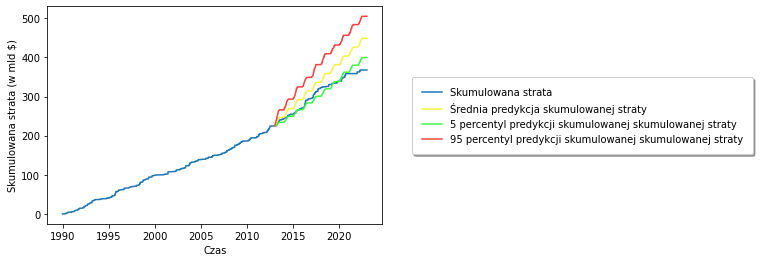

In [157]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_ln_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_ln_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_ln_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_ln_sin_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [158]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootstrap_avg),scale=np.exp(ln_mu_bootstrap_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_ln_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_ln_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_power_law_ln_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [39:32<00:00,  4.74s/it]


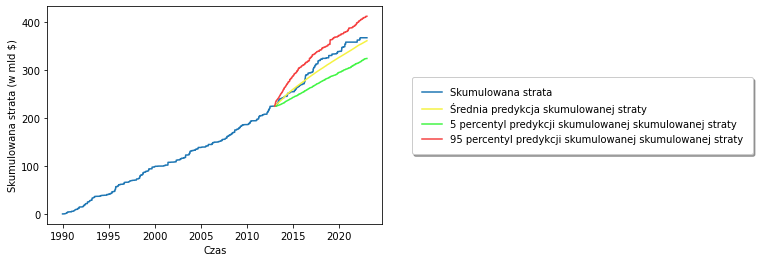

In [159]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_ln_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_ln_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_ln_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_ln_power_law_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład gamma

Sinusoidalna funkcja intensywności

In [160]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootstrap_avg,scale=1/gamma_beta_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_gamma_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_gamma_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_gamma_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [48:40<00:00,  5.84s/it]


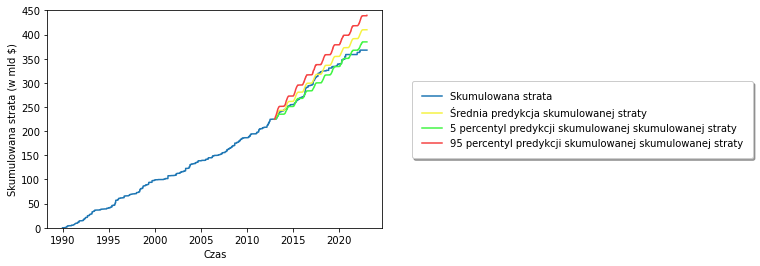

In [270]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_gamma_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_gamma_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_gamma_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_gamma_sin_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [162]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootstrap_avg,scale=1/gamma_beta_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_gamma_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_gamma_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_power_law_gamma_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [30:46<00:00,  3.69s/it]


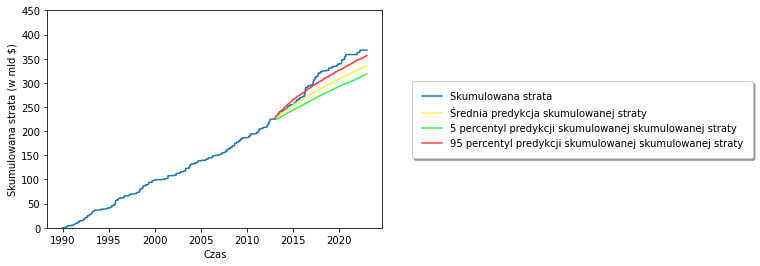

In [271]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_gamma_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_gamma_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_gamma_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_gamma_power_law_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Weibulla

Sinusoidalna funkcja intensywności

In [164]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootstrap_avg,scale=weibull_lambda_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_weibull_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_weibull_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_weibull_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:11:24<00:00,  8.57s/it]


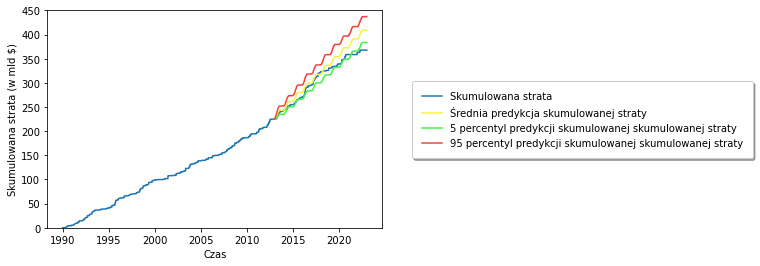

In [272]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_weibull_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_weibull_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_weibull_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_weibull_sin_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [166]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootstrap_avg,scale=weibull_lambda_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_weibull_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_weibull_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_power_law_weibull_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:01:51<00:00,  7.42s/it]


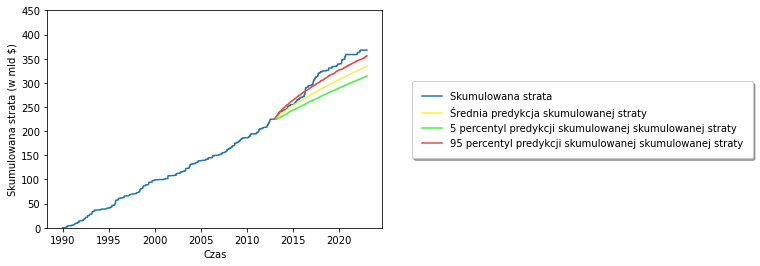

In [273]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_weibull_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_weibull_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_weibull_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_weibull_power_law_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Burra

Sinusoidalna funkcja intensywności

In [168]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootstrap_avg,d=burr_k_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_burr_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_burr_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_sin_burr_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:20:15<00:00,  9.63s/it]


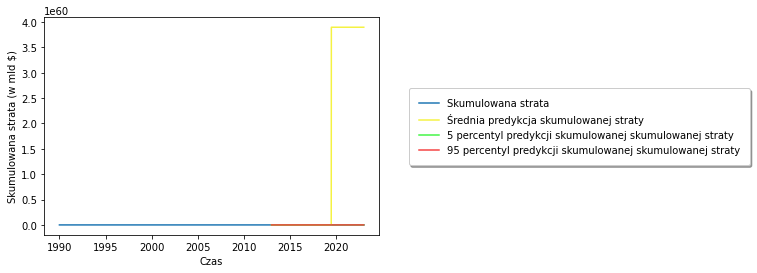

In [169]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_burr_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_burr_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_burr_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_burr_sin_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [170]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootstrap_avg,d=burr_k_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_burr_bootstrap_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_bootstrap_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_bootstrap_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_burr_bootstrap = np.sum(MSE_array)/number_of_simulations
MAE_power_law_burr_bootstrap = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [54:09<00:00,  6.50s/it] 


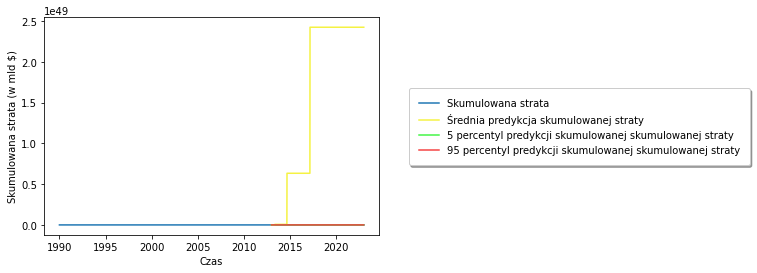

In [171]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_burr_bootstrap_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_burr_bootstrap_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_burr_bootstrap_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\cum_loss_burr_power_law_bootstrap_avg.pdf",bbox_inches='tight')
plt.show()

### Wyniki

In [172]:
# Wyniki

print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':["{:e}".format(MSE_sin_exp_bootstrap),"{:e}".format(MSE_power_law_exp_bootstrap),"{:e}".format(MSE_sin_ln_bootstrap),"{:e}".format(MSE_power_law_ln_bootstrap),"{:e}".format(MSE_sin_gamma_bootstrap),"{:e}".format(MSE_power_law_gamma_bootstrap),"{:e}".format(MSE_sin_weibull_bootstrap),"{:e}".format(MSE_power_law_weibull_bootstrap),"{:e}".format(MSE_sin_burr_bootstrap),"{:e}".format(MSE_power_law_burr_bootstrap)],
    'MAE':["{:e}".format(MAE_sin_exp_bootstrap),"{:e}".format(MAE_power_law_exp_bootstrap),"{:e}".format(MAE_sin_ln_bootstrap),"{:e}".format(MAE_power_law_ln_bootstrap),"{:e}".format(MAE_sin_gamma_bootstrap),"{:e}".format(MAE_power_law_gamma_bootstrap),"{:e}".format(MAE_sin_weibull_bootstrap),"{:e}".format(MAE_power_law_weibull_bootstrap),"{:e}".format(MAE_sin_burr_bootstrap),"{:e}".format(MAE_power_law_burr_bootstrap)]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.162674e+16  2.672604e+08
1  Wykładniczy     Power Law   3.740044e+16  1.930681e+08
2  Lognormalny  Sinusoidalna   9.483335e+16  3.062314e+08
3  Lognormalny     Power Law   4.874634e+16  2.186909e+08
4        Gamma  Sinusoidalna   7.160415e+16  2.670838e+08
5        Gamma     Power Law   3.752408e+16  1.933260e+08
6     Weibulla  Sinusoidalna   7.108349e+16  2.660849e+08
7     Weibulla     Power Law   3.685161e+16  1.915218e+08
8        Burra  Sinusoidalna  7.592936e+135  3.896905e+66
9        Burra     Power Law  1.799255e+113  2.423873e+55


In [173]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':[MSE_sin_exp_bootstrap,MSE_power_law_exp_bootstrap,MSE_sin_ln_bootstrap,MSE_power_law_ln_bootstrap,MSE_sin_gamma_bootstrap,MSE_power_law_gamma_bootstrap,MSE_sin_weibull_bootstrap,MSE_power_law_weibull_bootstrap,MSE_sin_burr_bootstrap,MSE_power_law_burr_bootstrap],
    'MAE':[MAE_sin_exp_bootstrap,MAE_power_law_exp_bootstrap,MAE_sin_ln_bootstrap,MAE_power_law_ln_bootstrap,MAE_sin_gamma_bootstrap,MAE_power_law_gamma_bootstrap,MAE_sin_weibull_bootstrap,MAE_power_law_weibull_bootstrap,MAE_sin_burr_bootstrap,MAE_power_law_burr_bootstrap]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.162674e+16  2.672604e+08
1  Wykładniczy     Power Law   3.740044e+16  1.930681e+08
2  Lognormalny  Sinusoidalna   9.483335e+16  3.062314e+08
3  Lognormalny     Power Law   4.874634e+16  2.186909e+08
4        Gamma  Sinusoidalna   7.160415e+16  2.670838e+08
5        Gamma     Power Law   3.752408e+16  1.933260e+08
6     Weibulla  Sinusoidalna   7.108349e+16  2.660849e+08
7     Weibulla     Power Law   3.685161e+16  1.915218e+08
8        Burra  Sinusoidalna  7.592936e+135  3.896905e+66
9        Burra     Power Law  1.799255e+113  2.423873e+55


In [261]:
print(pd.DataFrame
({
    'model': ['Bootstrap','Bootstrap','Bootstrap','Bootstrap','Bootstrap','Bootstrap','Bootstrap','Bootstrap'],
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'Zaobserwowana liczba':[float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6],
    '5 percentyl':[(float(cum_losses_sin_exp_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootstrap_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    'Średnia predykcja':[(float(cum_losses_sin_exp_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootstrap_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    '95 percentyl':[(float(cum_losses_sin_exp_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootstrap_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6]
}))

       model      rozkład       funkcja  Zaobserwowana liczba  5 percentyl  \
0  Bootstrap  Wykładniczy  Sinusoidalna            367.695185   387.635918   
1  Bootstrap  Wykładniczy     Power Law            367.695185   318.350026   
2  Bootstrap  Lognormalny  Sinusoidalna            367.695185   399.981690   
3  Bootstrap  Lognormalny     Power Law            367.695185   324.442145   
4  Bootstrap        Gamma  Sinusoidalna            367.695185   384.727943   
5  Bootstrap        Gamma     Power Law            367.695185   318.629450   
6  Bootstrap     Weibulla  Sinusoidalna            367.695185   383.607189   
7  Bootstrap     Weibulla     Power Law            367.695185   314.128423   

   Średnia predykcja  95 percentyl  
0         410.066337    432.662041  
1         335.874090    355.866872  
2         449.037385    505.107928  
3         361.496828    412.594749  
4         409.889713    439.671370  
5         336.131945    357.147588  
6         408.890824    437.284737  
7

Rozkład parametrów otrzymanych poprzez dopasowywanie do danych syntentycznych.

exp_lambda_bootstrap


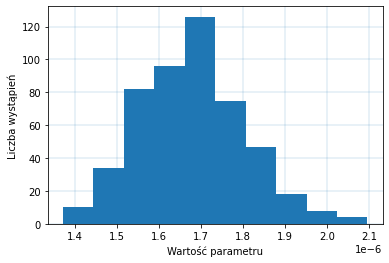

ln_mu_bootstrap


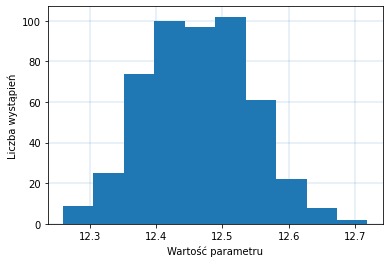

ln_sigma_sq_bootstrap


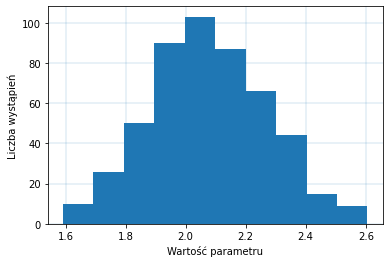

gamma_alfa_bootstrap


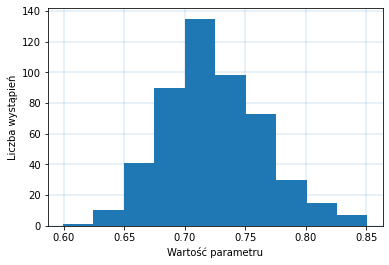

gamma_beta_bootstrap


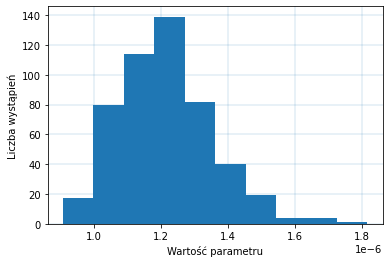

weibull_k_bootstrap


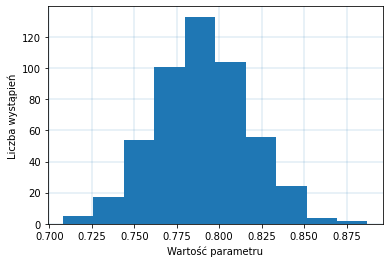

weibull_lambda_bootstrap


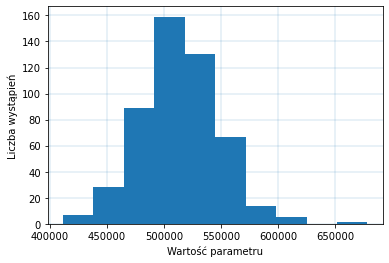

burr_c_bootstrap


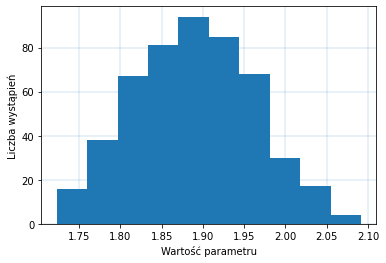

burr_k_bootstrap


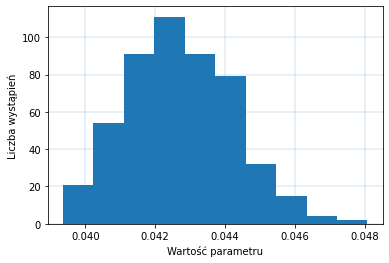

In [174]:
names = ["exp_lambda_bootstrap" ,"ln_mu_bootstrap" ,"ln_sigma_sq_bootstrap" ,"gamma_alfa_bootstrap" ,"gamma_beta_bootstrap" ,"weibull_k_bootstrap" ,"weibull_lambda_bootstrap" ,"burr_c_bootstrap" ,"burr_k_bootstrap"]
j = 0

for i in [exp_lambda_bootstrap ,
ln_mu_bootstrap ,
ln_sigma_sq_bootstrap ,
gamma_alfa_bootstrap ,
gamma_beta_bootstrap ,
weibull_k_bootstrap ,
weibull_lambda_bootstrap ,
burr_c_bootstrap ,
burr_k_bootstrap]:
    plt.hist(i)
    plt.xlabel("Wartość parametru")
    plt.ylabel("Liczba wystąpień")
    plt.grid(color='C0', linestyle='-', linewidth=0.2)
    plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootstrap\\"+names[j]+"_distribution.pdf",bbox_inches='tight')
    print(names[j])
    j += 1
    plt.show()

## Proces ryzyka

In [247]:
rp_number_of_simulations = 1000

In [255]:
def ruin_prob_bootstrap(u, theta, mu, lambda_func, lambda_func_params, loss_distribution, t_max, n):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        lambda_func: funkcja
            Funkcja intensywności
        loss_distribution: string
            Rozkład strat
        t_max: float
            Maksymalny czas symulacji
        n: int
            Liczba symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    negative = 0
    cum_losses = []
    MSE_array = []
    MAE_array = []
    I = integrate.quad(lambda x: lambda_func(x,lambda_func_params)[0],0, t_max)[0]
    C=(1+theta)*mu*I

    T = pd.DataFrame({'t':[t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
    for r in range(1,t_max):
        if r%4==0:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
        else:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    T.reset_index(drop=True,inplace=True)

    for i in tqdm(range(n)):
        N_loss = nhpp(lambda_func,lambda_func_params,len(np.floor(T['t']).unique()))

        if loss_distribution == "expon":
            damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootstrap_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "lognormal":
            damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootstrap_avg),scale=np.exp(ln_mu_bootstrap_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "gamma":
            damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootstrap_avg,scale=1/gamma_beta_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "weibull":
            damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootstrap_avg,scale=weibull_lambda_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "burr":
            damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootstrap_avg,d=burr_k_bootstrap_avg,size=1) for i in range(len(N_loss[1]))]).flatten()

        damages_loss_cum = loss_pred(T['t'],N_loss[1],damages_loss, T['t'])['damages']

        R = u + C - damages_loss_cum
        if np.sum(R<0) > 0:
            negative += 1

    return(negative/n)

### Funkcja intensywności typu Power Law

In [ ]:
rp_5_expon_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,1/exp_lambda_bootstrap_avg,power_law_int_fun,power_law_params,"expon",5,rp_number_of_simulations)
rp_10_expon_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,1/exp_lambda_bootstrap_avg,power_law_int_fun,power_law_params,"expon",10,rp_number_of_simulations)
rp_15_expon_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,1/exp_lambda_bootstrap_avg,power_law_int_fun,power_law_params,"expon",15,rp_number_of_simulations)
rp_20_expon_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,1/exp_lambda_bootstrap_avg,power_law_int_fun,power_law_params,"expon",20,rp_number_of_simulations)
rp_50_expon_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,1/exp_lambda_bootstrap_avg,power_law_int_fun,power_law_params,"expon",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:07:41<00:00, 61.66s/it] 


In [ ]:
rp_5_gamma_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,gamma_alfa_bootstrap_avg/gamma_beta_bootstrap_avg,power_law_int_fun,power_law_params,"gamma",5,rp_number_of_simulations)
rp_10_gamma_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,gamma_alfa_bootstrap_avg/gamma_beta_bootstrap_avg,power_law_int_fun,power_law_params,"gamma",10,rp_number_of_simulations)
rp_15_gamma_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,gamma_alfa_bootstrap_avg/gamma_beta_bootstrap_avg,power_law_int_fun,power_law_params,"gamma",15,rp_number_of_simulations)
rp_20_gamma_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,gamma_alfa_bootstrap_avg/gamma_beta_bootstrap_avg,power_law_int_fun,power_law_params,"gamma",20,rp_number_of_simulations)
rp_50_gamma_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,gamma_alfa_bootstrap_avg/gamma_beta_bootstrap_avg,power_law_int_fun,power_law_params,"gamma",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:24:11<00:00, 62.65s/it]  


In [256]:
rp_5_weibull_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,weibull_lambda_bootstrap_avg*gamma(1+1/weibull_k_bootstrap_avg),power_law_int_fun,power_law_params,"weibull",5,rp_number_of_simulations)
rp_10_weibull_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,weibull_lambda_bootstrap_avg*gamma(1+1/weibull_k_bootstrap_avg),power_law_int_fun,power_law_params,"weibull",10,rp_number_of_simulations)
rp_15_weibull_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,weibull_lambda_bootstrap_avg*gamma(1+1/weibull_k_bootstrap_avg),power_law_int_fun,power_law_params,"weibull",15,rp_number_of_simulations)
rp_20_weibull_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,weibull_lambda_bootstrap_avg*gamma(1+1/weibull_k_bootstrap_avg),power_law_int_fun,power_law_params,"weibull",20,rp_number_of_simulations)
rp_50_weibull_power_law_bootstrap = ruin_prob_bootstrap(1e7,0.3,weibull_lambda_bootstrap_avg*gamma(1+1/weibull_k_bootstrap_avg),power_law_int_fun,power_law_params,"weibull",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [19:44:14<00:00, 71.05s/it]   


In [259]:
print(pd.DataFrame
({
    'rozkład':["Weibulla"],
    'funkcja':['Power Law'],
    '5 lat':[rp_5_weibull_power_law_bootstrap],
    '10 lat':[rp_10_weibull_power_law_bootstrap],
    '15 lat':[rp_15_weibull_power_law_bootstrap],
    '20 lat':[rp_20_weibull_power_law_bootstrap],
    '50 lat':[rp_50_weibull_power_law_bootstrap],
}))

    rozkład    funkcja  5 lat  10 lat  15 lat  20 lat  50 lat
0  Weibulla  Power Law  0.001   0.001     0.0     0.0     0.0


## Bootknife

In [73]:
def bootknife(data, S, B):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
    Zwraca:
        bootknife_data: pd.Series
            Próba bootknife       
    """
    X= []
    for i in range(B):
        obs_to_delete = random.choice(pd.Series(data).index)
        data_r = data.drop(obs_to_delete)
        X.append(S(pd.Series(data_r).sample(len(data),replace=True)))
    if B == len(data):
            index_temp = data.index
    else:
        index_temp = range(B)

    bootknife_data = pd.Series(X, name=data.name)
    
    return(bootknife_data)

In [216]:
def bootknife(data,distribution, B):
    """
    Argumenty:
        data: pd.Series
            Ciąg z którego próbkujemy
        distribution: fun
            Przyjęty rozkład
        B: float
            Liczba próbek bootstrapowych
    Zwraca:
        bootstrap_data: pd.Series
            Próba bootstrapowa          
    """
    if distribution == "exp":
        params = [[]]
    else:
        params = [[],[]]

    for i in range(B):
        obs_to_delete = random.choice(pd.Series(data).index)
        data_r = data.drop(obs_to_delete)
        print(len(data_r))
        X = pd.Series(data_r).sample(len(data),replace=True)
        if distribution == "exp":
            params[0].append(len(X)/sum(X))
        elif distribution == "ln":
            params[0].append(sum(np.log(X))/len(X))
            params[1].append(sum(np.square(np.log(X)-sum(np.log(X))/len(X)))/len(X))
        elif distribution == "gamma":
            params[0].append(stats.gamma.fit(X,floc=0)[0])
            params[1].append(1/stats.gamma.fit(X,floc=0)[2])
        elif distribution == "weibull":
            params[0].append(stats.weibull_min.fit(X,floc=0)[0])
            params[1].append(stats.weibull_min.fit(X,floc=0)[2])
        elif distribution == "burr":
            params[0].append(stats.burr12.fit(X,floc=0,fscale=1)[0])
            params[1].append(stats.burr12.fit(X,floc=0,fscale=1)[1])

    return(params)

In [180]:
exp_lambda_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"exp",number_of_simulations)[0]
ln_mu_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"ln",number_of_simulations)[0]
ln_sigma_sq_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"ln",number_of_simulations)[1]
gamma_alfa_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"gamma",number_of_simulations)[0]
gamma_beta_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"gamma",number_of_simulations)[1]
weibull_k_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"weibull",number_of_simulations)[0]
weibull_lambda_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"weibull",number_of_simulations)[1]
burr_c_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"burr",number_of_simulations)[0]
burr_k_bootknife = bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"burr",number_of_simulations)[1]

c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [74]:
exp_lambda_bootknife = []
ln_mu_bootknife = []
ln_sigma_sq_bootknife = []
gamma_alfa_bootknife = []
gamma_beta_bootknife = []
weibull_k_bootknife = []
weibull_lambda_bootknife = []
burr_c_bootknife = []
burr_k_bootknife = []

for i in range(number_of_simulations):
    damages = bootknife(train["Insured Damages, Adjusted (\'000 US$)"], np.mean, len(train["Insured Damages, Adjusted (\'000 US$)"]))

    exp_lambda_bootknife.append(len(damages)/sum(damages))
    ln_mu_bootknife.append(sum(np.log(damages))/len(damages))
    ln_sigma_sq_bootknife.append(sum(np.square(np.log(damages)-sum(np.log(damages))/len(damages)))/len(damages))
    gamma_alfa_bootknife.append(stats.gamma.fit(damages,floc=0)[0])
    gamma_beta_bootknife.append(1/stats.gamma.fit(damages,floc=0)[2])
    weibull_k_bootknife.append(stats.weibull_min.fit(damages,floc=0)[0])
    weibull_lambda_bootknife.append(stats.weibull_min.fit(damages,floc=0)[2])
    burr_c_bootknife.append(stats.burr12.fit(damages,floc=0,fscale=1)[0])
    burr_k_bootknife.append(stats.burr12.fit(damages,floc=0,fscale=1)[1])

c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [181]:
exp_lambda_bootknife_avg = np.mean(exp_lambda_bootknife)
exp_lambda_bootknife_5p = np.percentile(exp_lambda_bootknife,95)
exp_lambda_bootknife_95p = np.percentile(exp_lambda_bootknife,95)

ln_mu_bootknife_avg = np.mean(ln_mu_bootknife)
ln_mu_bootknife_5p = np.percentile(ln_mu_bootknife,95)
ln_mu_bootknife_95p = np.percentile(ln_mu_bootknife,95)

ln_sigma_sq_bootknife_avg = np.mean(ln_sigma_sq_bootknife)
ln_sigma_sq_bootknife_5p = np.percentile(ln_sigma_sq_bootknife,95)
ln_sigma_sq_bootknife_95p = np.percentile(ln_sigma_sq_bootknife,95)

gamma_alfa_bootknife_avg = np.mean(gamma_alfa_bootknife)
gamma_alfa_bootknife_5p = np.percentile(gamma_alfa_bootknife,95)
gamma_alfa_bootknife_95p = np.percentile(gamma_alfa_bootknife,95)

gamma_beta_bootknife_avg = np.mean(gamma_beta_bootknife)
gamma_beta_bootknife_5p = np.percentile(gamma_beta_bootknife,95)
gamma_beta_bootknife_95p = np.percentile(gamma_beta_bootknife,95)

weibull_k_bootknife_avg = np.mean(weibull_k_bootknife)
weibull_k_bootknife_5p = np.percentile(weibull_k_bootknife,95)
weibull_k_bootknife_95p = np.percentile(weibull_k_bootknife,95)

weibull_lambda_bootknife_avg = np.mean(weibull_lambda_bootknife)
weibull_lambda_bootknife_5p = np.percentile(weibull_lambda_bootknife,95)
weibull_lambda_bootknife_95p = np.percentile(weibull_lambda_bootknife,95)

burr_c_bootknife_avg = np.mean(burr_c_bootknife)
burr_c_bootknife_5p = np.percentile(burr_c_bootknife,95)
burr_c_bootknife_95p = np.percentile(burr_c_bootknife,95)

burr_k_bootknife_avg = np.mean(burr_k_bootknife)
burr_k_bootknife_5p = np.percentile(burr_k_bootknife,95)
burr_k_bootknife_95p = np.percentile(burr_k_bootknife,95)

In [291]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_bootknife_avg),
                    round(ln_mu_bootknife_avg,2),
                    round(ln_sigma_sq_bootknife_avg,2),
                    round(gamma_alfa_bootknife_avg,2),
                    "{:e}".format(gamma_beta_bootknife_avg),
                    round(weibull_k_bootknife_avg,2),
                    round(weibull_lambda_bootknife_avg,2),
                    round(burr_c_bootknife_avg,2),
                    round(burr_k_bootknife_avg,2),
        ],
    'Rożnice' : [
                    exp_lambda_bootknife_avg-exp_lambda,
                    ln_mu_bootknife_avg-ln_mu,
                    ln_sigma_sq-ln_sigma_sq_bootknife_avg,
                    gamma_alfa_bootknife_avg-gamma_alfa,
                    gamma_beta_bootknife_avg-gamma_beta,
                    weibull_k_bootknife_avg-weibull_k,
                    weibull_lambda_bootknife_avg-weibull_lambda,
                    burr_c_bootknife_avg-burr_c,
                    burr_k_bootknife_avg-burr_k,                
        ]
}))

       rozkład  Parametr       Wartość       Rożnice
0  Wykładniczy    lambda  1.680859e-06  1.337111e-08
1  Lognormalny        mu         12.47  1.554624e-03
2  Lognormalny  sigma_sq          2.06  1.369070e-02
3        Gamma      alfa          0.72  3.687237e-03
4        Gamma      beta  1.206248e-06  7.389155e-09
5     Weibulla         k          0.79  3.123361e-03
6     Weibulla    lambda     514926.24  7.556842e+02
7        Burra         c          1.88  1.989667e-02
8        Burra         k          0.04 -5.578424e-04


## Straty - avg

### Rozkład wykładniczy

Sinusoidalna funkcja intensywności

In [183]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootknife_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_exp_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_exp_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_sin_exp_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:02:24<00:00,  7.49s/it]


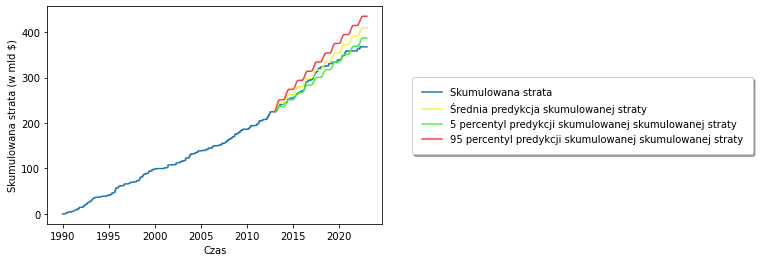

In [184]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_exp_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_exp_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_exp_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_exp_sin_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [185]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootknife_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_exp_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_exp_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_power_law_exp_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [31:08<00:00,  3.74s/it]


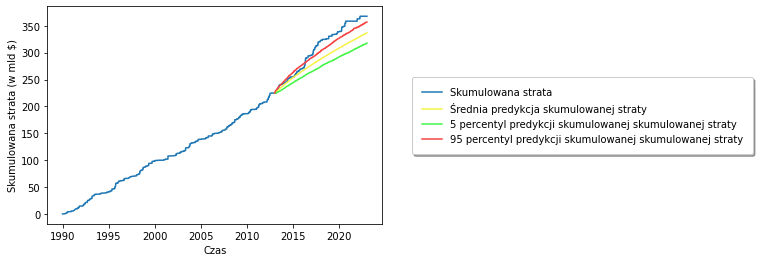

In [186]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_exp_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_exp_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_exp_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_exp_power_law_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład lognormalny

Sinusoidalna funkcja intensywności

In [187]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootknife_avg),scale=np.exp(ln_mu_bootknife_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_ln_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_ln_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_sin_ln_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [48:41<00:00,  5.84s/it]


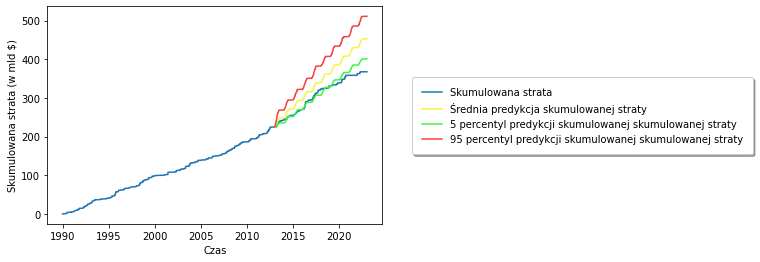

In [188]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_ln_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_ln_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_ln_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_ln_sin_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [189]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootknife_avg),scale=np.exp(ln_mu_bootknife_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_ln_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_ln_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_power_law_ln_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [31:13<00:00,  3.75s/it]


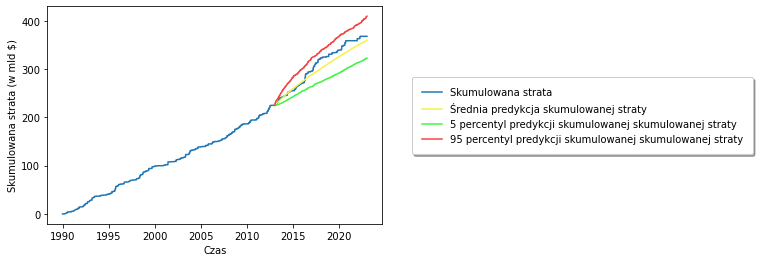

In [190]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_ln_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_ln_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_ln_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_ln_power_law_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład gamma

Sinusoidalna funkcja intensywności

In [191]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootknife_avg,scale=1/gamma_beta_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_gamma_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_gamma_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_sin_gamma_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [47:58<00:00,  5.76s/it]


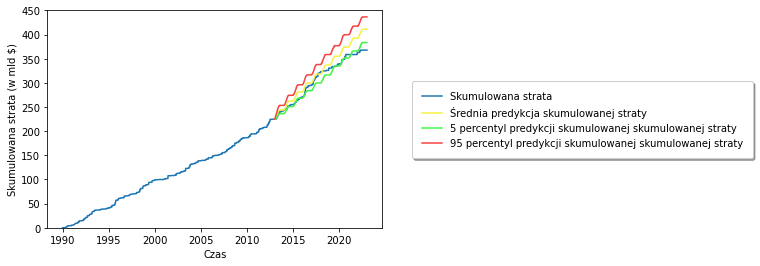

In [274]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_gamma_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_gamma_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_gamma_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_gamma_sin_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [193]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootknife_avg,scale=1/gamma_beta_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_gamma_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_gamma_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_power_law_gamma_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [30:50<00:00,  3.70s/it]


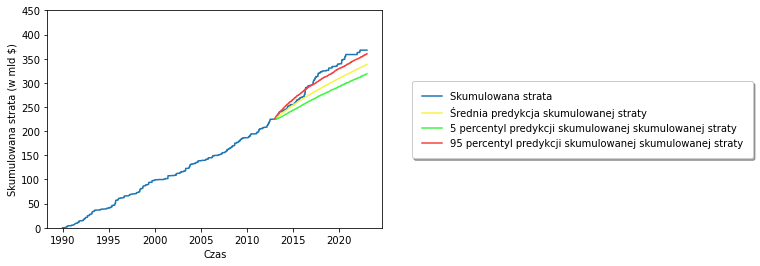

In [275]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_gamma_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_gamma_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_gamma_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_gamma_power_law_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Weibulla

Sinusoidalna funkcja intensywności

In [195]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootknife_avg,scale=weibull_lambda_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_weibull_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_weibull_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_sin_weibull_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [51:42<00:00,  6.20s/it]


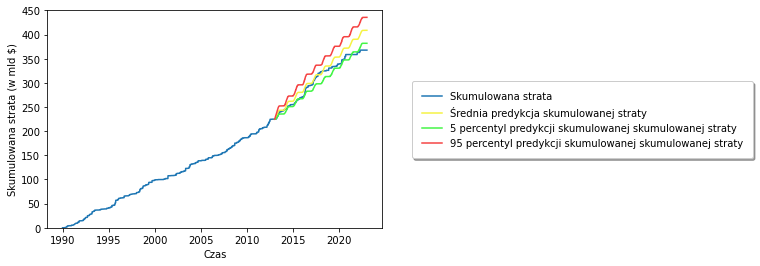

In [276]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_weibull_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_weibull_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_weibull_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_weibull_sin_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [197]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootknife_avg,scale=weibull_lambda_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_weibull_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_weibull_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_power_law_weibull_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [30:30<00:00,  3.66s/it]


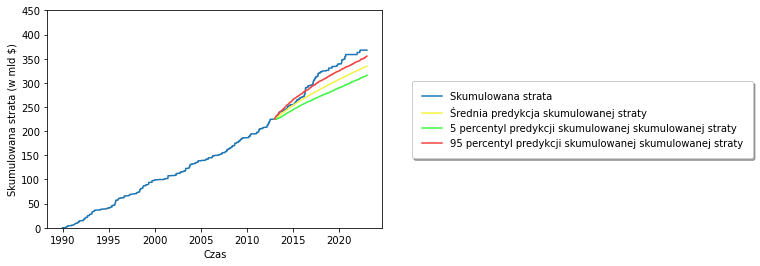

In [277]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_weibull_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_weibull_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_weibull_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_weibull_power_law_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Burra

Sinusoidalna funkcja intensywności

In [199]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootknife_avg,d=burr_k_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_burr_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_burr_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_sin_burr_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [49:31<00:00,  5.94s/it]


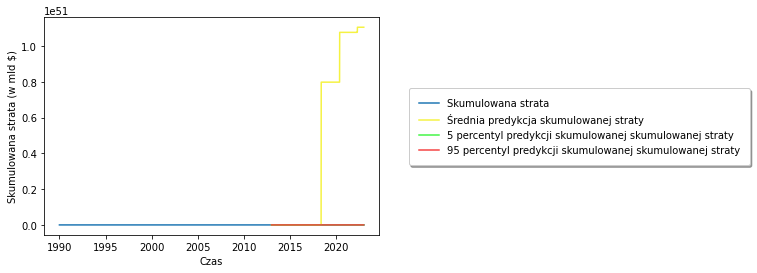

In [200]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_burr_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_burr_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_burr_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_burr_sin_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [201]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootknife_avg,d=burr_k_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_burr_bootknife_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_bootknife_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_bootknife_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_burr_bootknife = np.sum(MSE_array)/number_of_simulations
MAE_power_law_burr_bootknife = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [30:50<00:00,  3.70s/it]


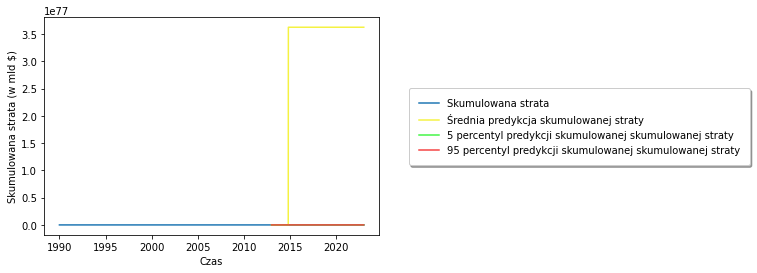

In [202]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_burr_bootknife_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_burr_bootknife_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_burr_bootknife_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\cum_loss_burr_power_law_bootknife_avg.pdf",bbox_inches='tight')
plt.show()

### Wyniki

In [203]:
# Wyniki

print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':["{:e}".format(MSE_sin_exp_bootknife),"{:e}".format(MSE_power_law_exp_bootknife),"{:e}".format(MSE_sin_ln_bootknife),"{:e}".format(MSE_power_law_ln_bootknife),"{:e}".format(MSE_sin_gamma_bootknife),"{:e}".format(MSE_power_law_gamma_bootknife),"{:e}".format(MSE_sin_weibull_bootknife),"{:e}".format(MSE_power_law_weibull_bootknife),"{:e}".format(MSE_sin_burr_bootknife),"{:e}".format(MSE_power_law_burr_bootknife)],
    'MAE':["{:e}".format(MAE_sin_exp_bootknife),"{:e}".format(MAE_power_law_exp_bootknife),"{:e}".format(MAE_sin_ln_bootknife),"{:e}".format(MAE_power_law_ln_bootknife),"{:e}".format(MAE_sin_gamma_bootknife),"{:e}".format(MAE_power_law_gamma_bootknife),"{:e}".format(MAE_sin_weibull_bootknife),"{:e}".format(MAE_power_law_weibull_bootknife),"{:e}".format(MAE_sin_burr_bootknife),"{:e}".format(MAE_power_law_burr_bootknife)]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.149445e+16  2.669757e+08
1  Wykładniczy     Power Law   3.777696e+16  1.939586e+08
2  Lognormalny  Sinusoidalna   9.753926e+16  3.105001e+08
3  Lognormalny     Power Law   4.761988e+16  2.166814e+08
4        Gamma  Sinusoidalna   7.217206e+16  2.681660e+08
5        Gamma     Power Law   3.824686e+16  1.951430e+08
6     Weibulla  Sinusoidalna   7.098476e+16  2.659185e+08
7     Weibulla     Power Law   3.696375e+16  1.918846e+08
8        Burra  Sinusoidalna  3.582875e+116  1.105683e+57
9        Burra     Power Law  6.572557e+169  3.625619e+83


In [204]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':[MSE_sin_exp_bootknife,MSE_power_law_exp_bootknife,MSE_sin_ln_bootknife,MSE_power_law_ln_bootknife,MSE_sin_gamma_bootknife,MSE_power_law_gamma_bootknife,MSE_sin_weibull_bootknife,MSE_power_law_weibull_bootknife,MSE_sin_burr_bootknife,MSE_power_law_burr_bootknife],
    'MAE':[MAE_sin_exp_bootknife,MAE_power_law_exp_bootknife,MAE_sin_ln_bootknife,MAE_power_law_ln_bootknife,MAE_sin_gamma_bootknife,MAE_power_law_gamma_bootknife,MAE_sin_weibull_bootknife,MAE_power_law_weibull_bootknife,MAE_sin_burr_bootknife,MAE_power_law_burr_bootknife]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.149445e+16  2.669757e+08
1  Wykładniczy     Power Law   3.777696e+16  1.939586e+08
2  Lognormalny  Sinusoidalna   9.753926e+16  3.105001e+08
3  Lognormalny     Power Law   4.761988e+16  2.166814e+08
4        Gamma  Sinusoidalna   7.217206e+16  2.681660e+08
5        Gamma     Power Law   3.824686e+16  1.951430e+08
6     Weibulla  Sinusoidalna   7.098476e+16  2.659185e+08
7     Weibulla     Power Law   3.696375e+16  1.918846e+08
8        Burra  Sinusoidalna  3.582875e+116  1.105683e+57
9        Burra     Power Law  6.572557e+169  3.625619e+83


In [262]:
print(pd.DataFrame
({
    'model': ['Bootknife','Bootknife','Bootknife','Bootknife','Bootknife','Bootknife','Bootknife','Bootknife'],
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'Zaobserwowana liczba':[float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6],
    '5 percentyl':[(float(cum_losses_sin_exp_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootknife_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    'Średnia predykcja':[(float(cum_losses_sin_exp_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootknife_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    '95 percentyl':[(float(cum_losses_sin_exp_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_bootknife_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6]
}))

       model      rozkład       funkcja  Zaobserwowana liczba  5 percentyl  \
0  Bootknife  Wykładniczy  Sinusoidalna            367.695185   387.254357   
1  Bootknife  Wykładniczy     Power Law            367.695185   317.552190   
2  Bootknife  Lognormalny  Sinusoidalna            367.695185   401.087872   
3  Bootknife  Lognormalny     Power Law            367.695185   322.814091   
4  Bootknife        Gamma  Sinusoidalna            367.695185   383.472671   
5  Bootknife        Gamma     Power Law            367.695185   318.797024   
6  Bootknife     Weibulla  Sinusoidalna            367.695185   381.849859   
7  Bootknife     Weibulla     Power Law            367.695185   315.854723   

   Średnia predykcja  95 percentyl  
0         409.781609    434.991791  
1         336.764517    356.851334  
2         453.306076    511.409580  
3         359.487362    409.266013  
4         410.971925    436.450195  
5         337.949004    360.291390  
6         408.724464    435.555822  
7

Rozkład parametrów otrzymanych poprzez dopasowywanie do danych syntentycznych.

In [230]:
def bootknife(data,distribution, B):
    """
    Argumenty:
        data: pd.Series
            Ciąg z którego próbkujemy
        distribution: fun
            Przyjęty rozkład
        B: float
            Liczba próbek bootstrapowych
    Zwraca:
        bootstrap_data: pd.Series
            Próba bootstrapowa          
    """
    if distribution == "exp":
        params = [[]]
    else:
        params = [[],[]]

    for i in range(B):
        obs_to_delete = random.sample(pd.Series(data).index, 10)
        data_r = data.drop(obs_to_delete)
        print(len(data_r))
        X = pd.Series(data_r).sample(len(data),replace=True)
        if distribution == "exp":
            params[0].append(len(X)/sum(X))
        elif distribution == "ln":
            params[0].append(sum(np.log(X))/len(X))
            params[1].append(sum(np.square(np.log(X)-sum(np.log(X))/len(X)))/len(X))
        elif distribution == "gamma":
            params[0].append(stats.gamma.fit(X,floc=0)[0])
            params[1].append(1/stats.gamma.fit(X,floc=0)[2])
        elif distribution == "weibull":
            params[0].append(stats.weibull_min.fit(X,floc=0)[0])
            params[1].append(stats.weibull_min.fit(X,floc=0)[2])
        elif distribution == "burr":
            params[0].append(stats.burr12.fit(X,floc=0,fscale=1)[0])
            params[1].append(stats.burr12.fit(X,floc=0,fscale=1)[1])

    return(params)

In [231]:
a =  bootknife(train["Insured Damages, Adjusted (\'000 US$)"],"exp",number_of_simulations)[0]

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

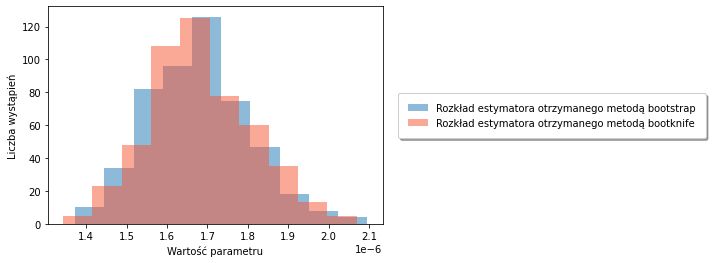

In [260]:
plt.hist(exp_lambda_bootstrap,alpha=0.5)
plt.hist(exp_lambda_bootknife,color="#f85431",alpha=0.5)
plt.xlabel("Wartość parametru")
plt.ylabel("Liczba wystąpień")
#plt.grid(color='C0', linestyle='-', linewidth=0.1)
plt.figlegend(['Rozkład estymatora otrzymanego metodą bootstrap','Rozkład estymatora otrzymanego metodą bootknife'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.66,0.5])
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\comparison_boot_distributions.pdf",bbox_inches='tight')
plt.show()

exp_lambda_bootknife


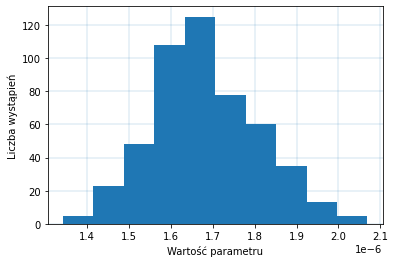

ln_mu_bootknife


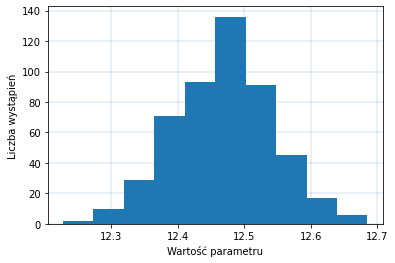

ln_sigma_sq_bootknife


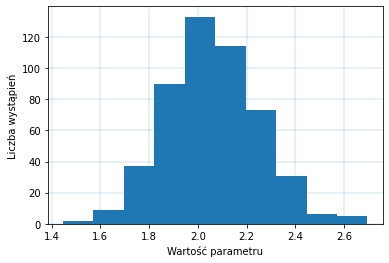

gamma_alfa_bootknife


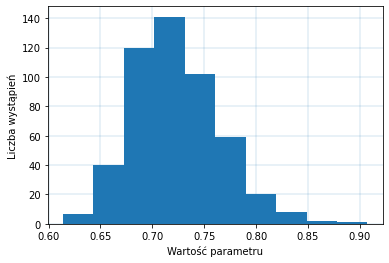

gamma_beta_bootknife


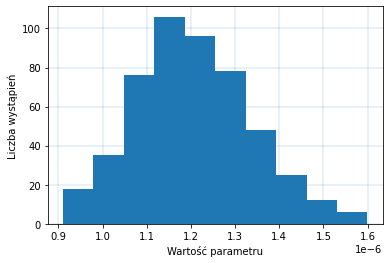

weibull_k_bootknife


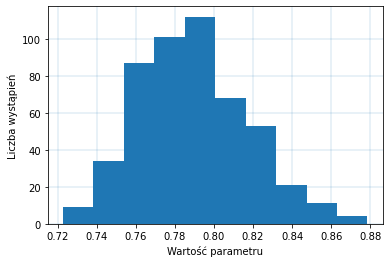

weibull_lambda_bootknife


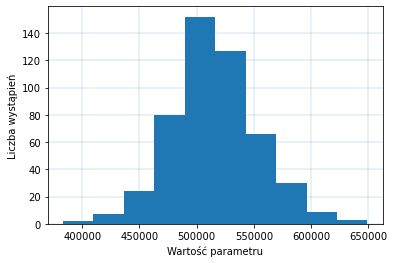

burr_c_bootknife


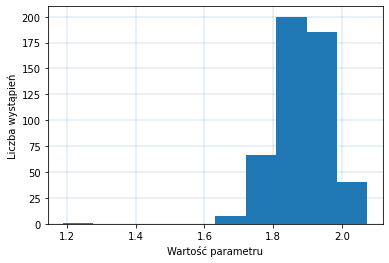

burr_k_bootknife


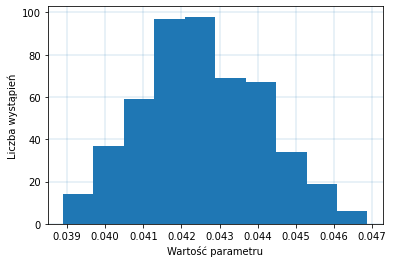

In [205]:
names = ["exp_lambda_bootknife" ,"ln_mu_bootknife" ,"ln_sigma_sq_bootknife" ,"gamma_alfa_bootknife" ,"gamma_beta_bootknife" ,"weibull_k_bootknife" ,"weibull_lambda_bootknife" ,"burr_c_bootknife" ,"burr_k_bootknife"]
j = 0

for i in [exp_lambda_bootknife ,
ln_mu_bootknife ,
ln_sigma_sq_bootknife ,
gamma_alfa_bootknife ,
gamma_beta_bootknife ,
weibull_k_bootknife ,
weibull_lambda_bootknife ,
burr_c_bootknife ,
burr_k_bootknife]:
    plt.hist(i)
    plt.xlabel("Wartość parametru")
    plt.ylabel("Liczba wystąpień")
    plt.grid(color='C0', linestyle='-', linewidth=0.2)
    plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje Bootknife\\"+names[j]+"_distribution.pdf",bbox_inches='tight')
    print(names[j])
    j += 1
    plt.show()

## Proces ryzyka

In [263]:
rp_number_of_simulations = 1000

In [267]:
def ruin_prob_bootknife(u, theta, mu, lambda_func, lambda_func_params, loss_distribution, t_max, n):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        lambda_func: funkcja
            Funkcja intensywności
        loss_distribution: string
            Rozkład strat
        t_max: float
            Maksymalny czas symulacji
        n: int
            Liczba symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    negative = 0
    cum_losses = []
    MSE_array = []
    MAE_array = []
    I = integrate.quad(lambda x: lambda_func(x,lambda_func_params)[0],0, t_max)[0]
    C=(1+theta)*mu*I

    T = pd.DataFrame({'t':[t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
    for r in range(1,t_max):
        if r%4==0:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
        else:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    T.reset_index(drop=True,inplace=True)

    for i in tqdm(range(n)):
        N_loss = nhpp(lambda_func,lambda_func_params,len(np.floor(T['t']).unique()))

        if loss_distribution == "expon":
            damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_bootknife_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "lognormal":
            damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_bootknife_avg),scale=np.exp(ln_mu_bootknife_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "gamma":
            damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_bootknife_avg,scale=1/gamma_beta_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "weibull":
            damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_bootknife_avg,scale=weibull_lambda_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "burr":
            damages_loss = np.array([stats.burr12.rvs(c=burr_c_bootknife_avg,d=burr_k_bootknife_avg,size=1) for i in range(len(N_loss[1]))]).flatten()

        damages_loss_cum = loss_pred(T['t'],N_loss[1],damages_loss, T['t'])['damages']

        R = u + C - damages_loss_cum
        if np.sum(R<0) > 0:
            negative += 1

    return(negative/n)

### Funkcja intensywności typu Power Law

In [ ]:
rp_5_expon_power_law_bootknife = ruin_prob(1e7,0.3,1/exp_lambda_bootknife,power_law_int_fun,power_law_params,"expon",5,rp_number_of_simulations)
rp_10_expon_power_law_bootknife = ruin_prob(1e7,0.3,1/exp_lambda_bootknife,power_law_int_fun,power_law_params,"expon",10,rp_number_of_simulations)
rp_15_expon_power_law_bootknife = ruin_prob(1e7,0.3,1/exp_lambda_bootknife,power_law_int_fun,power_law_params,"expon",15,rp_number_of_simulations)
rp_20_expon_power_law_bootknife = ruin_prob(1e7,0.3,1/exp_lambda_bootknife,power_law_int_fun,power_law_params,"expon",20,rp_number_of_simulations)
rp_50_expon_power_law_bootknife = ruin_prob(1e7,0.3,1/exp_lambda_bootknife,power_law_int_fun,power_law_params,"expon",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:07:41<00:00, 61.66s/it] 


In [ ]:
rp_5_gamma_power_law_bootknife = ruin_prob(1e7,0.3,gamma_alfa_bootknife/gamma_beta_bootknife,power_law_int_fun,power_law_params,"gamma",5,rp_number_of_simulations)
rp_10_gamma_power_law_bootknife = ruin_prob(1e7,0.3,gamma_alfa_bootknife/gamma_beta_bootknife,power_law_int_fun,power_law_params,"gamma",10,rp_number_of_simulations)
rp_15_gamma_power_law_bootknife = ruin_prob(1e7,0.3,gamma_alfa_bootknife/gamma_beta_bootknife,power_law_int_fun,power_law_params,"gamma",15,rp_number_of_simulations)
rp_20_gamma_power_law_bootknife = ruin_prob(1e7,0.3,gamma_alfa_bootknife/gamma_beta_bootknife,power_law_int_fun,power_law_params,"gamma",20,rp_number_of_simulations)
rp_50_gamma_power_law_bootknife = ruin_prob(1e7,0.3,gamma_alfa_bootknife/gamma_beta_bootknife,power_law_int_fun,power_law_params,"gamma",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:24:11<00:00, 62.65s/it]  


In [268]:
rp_5_weibull_power_law_bootknife = ruin_prob_bootknife(1e7,0.3,weibull_lambda_bootknife_avg*gamma(1+1/weibull_k_bootknife_avg),power_law_int_fun,power_law_params,"weibull",5,rp_number_of_simulations)
rp_10_weibull_power_law_bootknife = ruin_prob_bootknife(1e7,0.3,weibull_lambda_bootknife_avg*gamma(1+1/weibull_k_bootknife_avg),power_law_int_fun,power_law_params,"weibull",10,rp_number_of_simulations)
rp_15_weibull_power_law_bootknife = ruin_prob_bootknife(1e7,0.3,weibull_lambda_bootknife_avg*gamma(1+1/weibull_k_bootknife_avg),power_law_int_fun,power_law_params,"weibull",15,rp_number_of_simulations)
rp_20_weibull_power_law_bootknife = ruin_prob_bootknife(1e7,0.3,weibull_lambda_bootknife_avg*gamma(1+1/weibull_k_bootknife_avg),power_law_int_fun,power_law_params,"weibull",20,rp_number_of_simulations)
rp_50_weibull_power_law_bootknife = ruin_prob_bootknife(1e7,0.3,weibull_lambda_bootknife_avg*gamma(1+1/weibull_k_bootknife_avg),power_law_int_fun,power_law_params,"weibull",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [21:12:59<00:00, 76.38s/it]   


In [ ]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy',"Gamma","Weibulla"],
    'funkcja':['Power Law','Power Law','Power Law'],
    '5 lat':[rp_5_expon_power_law_bootknife,rp_5_gamma_power_law_bootknife,rp_5_weibull_power_law_bootknife],
    '10 lat':[rp_10_expon_power_law_bootknife,rp_10_gamma_power_law_bootknife,rp_10_weibull_power_law_bootknife],
    '15 lat':[rp_15_expon_power_law_bootknife,rp_15_gamma_power_law_bootknife,rp_15_weibull_power_law_bootknife],
    '20 lat':[rp_20_expon_power_law_bootknife,rp_20_gamma_power_law_bootknife,rp_20_weibull_power_law_bootknife],
    '50 lat':[rp_50_expon_power_law_bootknife,rp_50_gamma_power_law_bootknife,rp_50_weibull_power_law_bootknife],
}))

       rozkład    funkcja  5 lat  10 lat  15 lat  20 lat  50 lat
0  Wykładniczy  Power Law  0.000   0.000     0.0     0.0     0.0
1        Gamma  Power Law  0.000   0.000     0.0     0.0     0.0
2     Weibulla  Power Law  0.001   0.002     0.0     0.0     0.0


In [269]:
print(pd.DataFrame
({
    'rozkład':["Weibulla"],
    'funkcja':['Power Law'],
    '5 lat':[rp_5_weibull_power_law_bootstrap],
    '10 lat':[rp_10_weibull_power_law_bootstrap],
    '15 lat':[rp_15_weibull_power_law_bootstrap],
    '20 lat':[rp_20_weibull_power_law_bootstrap],
    '50 lat':[rp_50_weibull_power_law_bootstrap],
}))

    rozkład    funkcja  5 lat  10 lat  15 lat  20 lat  50 lat
0  Weibulla  Power Law  0.001   0.001     0.0     0.0     0.0


# STARE PODEJŚCIE

In [ ]:
def bootstrap(data,S , B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        X.append(S(pd.Series(data).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[S(X)-stats.t.ppf(1-2.5/100,len(X)-1)*std/np.sqrt(len(X)),S(X)-stats.t.ppf(2.5/100,len(X)-1)*std/np.sqrt(len(X))])
    return(S(X),std,[S(X)-stats.t.ppf(1-2.5/100,len(X)-1)*std/np.sqrt(len(X)),S(X)-stats.t.ppf(2.5/100,len(X)-1)*std/np.sqrt(len(X))])

In [ ]:
def bootstrap(data,S ,alpha, B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        S: fun
            Statystka
        alpha: float
            Poziom istotności    
        B: float
            Liczba próbek bootstrapowych
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        X.append(S(pd.Series(data).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[round(np.percentile(X,alpha/2),2),round(np.percentile(X,100-alpha/2),2)])
    return(S(X),std,[np.percentile(X,alpha/2),np.percentile(X,100-alpha/2)],X)

In [ ]:
b = bootstrap(train['Insured Damages, Adjusted (\'000 US$)'],np.mean,5,100)

S:  604433.11 std(S):  41769.42 CI:  [526997.07, 671604.86]


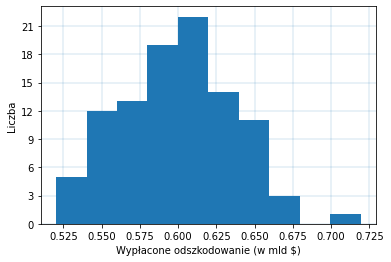

In [ ]:
plt.hist(np.array(b[3])/1e6)
plt.xlabel("Wypłacone odszkodowanie (w mld $)")
plt.ylabel("Liczba")
plt.grid(color='C0', linestyle='-', linewidth=0.2)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xlim(left=0)
#ax.set_yticks(np.linspace(1,11,num=11))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\bootstrap_hist.pdf")
plt.show()

In [ ]:
stats.bootstrap((train['Insured Damages, Adjusted (\'000 US$)'],),np.mean,confidence_level=0.95)

BootstrapResult(confidence_interval=ConfidenceInterval(low=521450.3072545228, high=694631.5955569998), standard_error=44283.81255742042)

In [ ]:
cum_losses_sin_exp_avg

,damages
t,
2013.000000,0.000000e+00
2013.002740,2.539095e+04
2013.005479,6.246515e+04
2013.008219,9.904594e+04
2013.010959,1.297125e+05
...,...
2022.986301,2.180131e+08
2022.989041,2.180313e+08
2022.991781,2.180503e+08


In [ ]:
loss_test_bootstrap = pd.merge(T_test, pd.DataFrame({'t':test['t'], "Mean":b[0], "LB": b[2][0], "UB": b[2][1]}), on='t', how='left').fillna(0).groupby('t').sum()
cum_loss_test_bootstrap = loss_test_bootstrap.cumsum()

In [ ]:
bootstrap = pd.DataFrame({"Mean":b[0], "LB": b[2][0], "UB": b[2][1]},index=loss_test.index)
cum_bootstrap = bootstrap.cumsum()

In [ ]:
cum_loss_test_bootstrap

,Mean,LB,UB
t,,,
2013.000000,0.000000e+00,0.000000e+00,0.000000e+00
2013.002740,0.000000e+00,0.000000e+00,0.000000e+00
2013.005479,0.000000e+00,0.000000e+00,0.000000e+00
2013.008219,0.000000e+00,0.000000e+00,0.000000e+00
2013.010959,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...
2022.986301,8.255627e+07,7.186365e+07,9.415050e+07
2022.989041,8.255627e+07,7.186365e+07,9.415050e+07
2022.991781,8.255627e+07,7.186365e+07,9.415050e+07


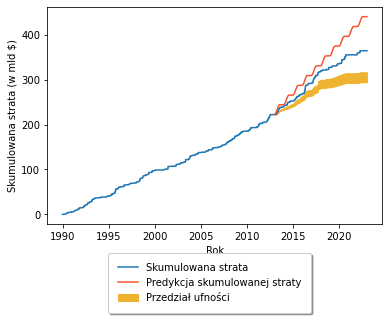

In [ ]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_exp_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")
plt.fill_between(cum_loss_test_bootstrap.index,(cum_loss_test_bootstrap["LB"]+float(cum_loss_train["damages"].tail(1)))/1e6,(cum_loss_test_bootstrap["UB"]+float(cum_loss_train["damages"].tail(1)))/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty', 'Przedział ufności'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_sin_bootstrap.pdf",bbox_inches='tight')
plt.show()

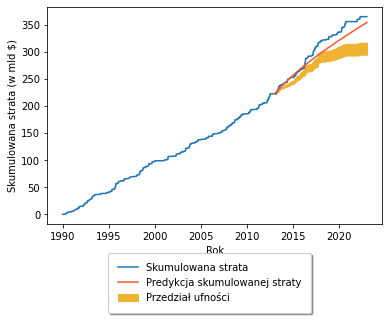

In [ ]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_exp_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f85431")
plt.fill_between(cum_loss_test_bootstrap.index,(cum_loss_test_bootstrap["LB"]+float(cum_loss_train["damages"].tail(1)))/1e6,(cum_loss_test_bootstrap["UB"]+float(cum_loss_train["damages"].tail(1)))/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty', 'Przedział ufności'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_sin_bootstrap.pdf",bbox_inches='tight')
plt.show()

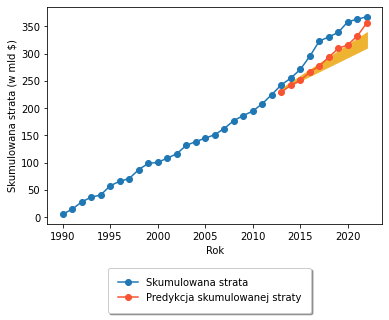

In [ ]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_ln.index,(cum_bootstrap["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootstrap["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_sin_bootstrap.pdf",bbox_inches='tight')
plt.show()

### Bootknife

In [ ]:
def bootknife(data,S ,alpha, B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
        alpha: float
            Poziom istotności
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        obs_to_delete = random.choice(pd.Series(data).index)
        data_r = data.drop(obs_to_delete)
        X.append(S(pd.Series(data_r).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[round(np.percentile(X,alpha/2),2),round(np.percentile(X,100-alpha/2),2)])
    return(S(X),std,[np.percentile(X,alpha/2),np.percentile(X,100-alpha/2)],X)

In [ ]:
b2 = bootknife(loss_train['Damages'],np.mean,5,100)

S:  9867131.01 std(S):  973764.36 CI:  [8148087.64, 11847820.25]


In [ ]:
bootknife = pd.DataFrame({"n":pd.Series(test.groupby('Year').count()['Dis No']), "Mean":b[0], "LB": b[2][0], "UB": b[2][1]})
cum_bootknife = bootknife.cumsum()

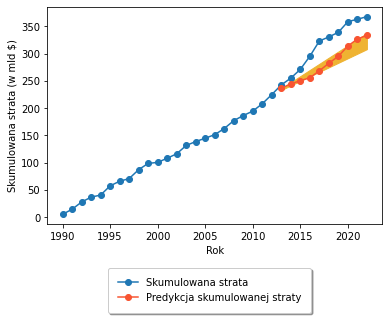

In [ ]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_exp["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_exp.index,(cum_bootknife["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootknife["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_exp_sin_bootknife.pdf",bbox_inches='tight')
plt.show()

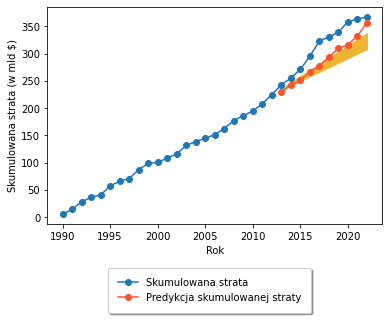

In [ ]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_ln.index,(cum_bootknife["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootknife["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje\\cum_loss_ln_sin_bootknife.pdf",bbox_inches='tight')
plt.show()